In [1]:
# import thư viện findspark và pyspark
import findspark
findspark.init()
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()

23/11/02 17:53:56 WARN Utils: Your hostname, nhom6h-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.59.133 instead (on interface ens33)
23/11/02 17:53:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 17:53:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

from pyspark.sql import SparkSession

# Tạo SparkSession và thêm cấu hình cho thư viện Elasticsearch
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.jars.packages", "org.elasticsearch:elasticsearch-spark-20_2.11:5.3.0") \
    .getOrCreate()

23/11/02 17:54:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Import các thư viện cần thiết để hiển thị hình ảnh, HTML và các nội dung khác trong IPython.
from IPython.display import Image, HTML, display
spark

In [5]:
# doc du lieu va in ra sl danh gia
PATH_TO_DATA = "data/ml-latest-small"
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Number of ratings: {}".format(ratings.count()))
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [6]:
# chon cot ratings
ratings = ratings.select(
ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



In [7]:
# tai tep csv vao spark
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [8]:
# show 5 hang dau tien ket qua
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [9]:
#tim kiem nam sx tu ten phim
import re

def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    

s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

In [10]:
# lam sach su lieu phim
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [11]:
movies.show(5, truncate=False)

+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [12]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

Successfully imported tmdbsimple!


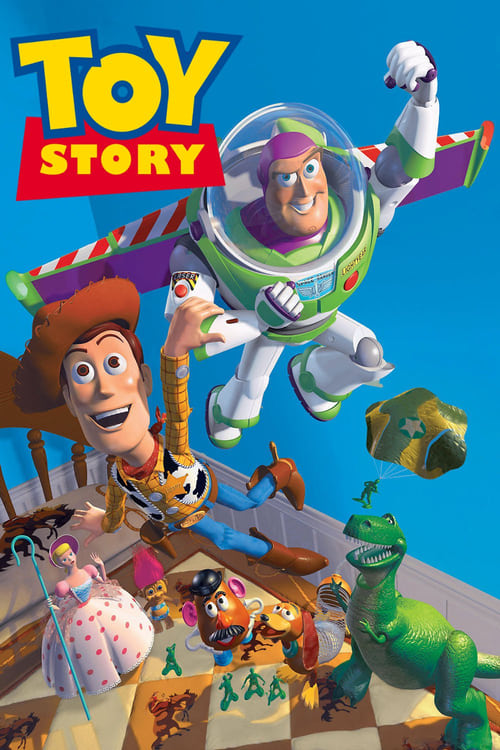

In [13]:
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = '7f6818b29376eeead0c5121872e96fae'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))

In [14]:
from elasticsearch import Elasticsearch

# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'name': 's1Jeo-g',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'isYREqdNRRebxDLr-BoP9Q',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

In [15]:
import elasticsearch

es = elasticsearch.Elasticsearch('localhost:9200')

# Index một tài liệu
es.index(index='my_index', doc_type='my_type', id=1, body={
    'user': {
        'id': 1,
        'name': 'John Doe',
        'email': 'johndoe@example.com'
    },
    'movie': {
        'id': 1,
        'title': 'The Shawshank Redemption',
        'year': 1994
    },
    'rating': {
        'user_id': 1,
        'movie_id': 1,
        'rating': 5
    }
})

# Xóa chỉ mục
es.indices.delete(index='my_index')

{'acknowledged': True}

In [16]:
es.indices.delete(index='demo')

{'acknowledged': True}

In [17]:
create_index = {
    "settings": {
        "analysis": {
            "analyzer": {

              "payload_analyzer":{
                "type": "custom",
                "tokenizer":"whitespace",
                "filter":"delimited_payload_filter"}}}},
    "mappings": {
        "ratings": {
# this mapping definition sets up the fields for the rating events
"properties": {
"timestamp": {
"type": "date"
},
"userId": {
"type": "integer"
},
"movieId": {
"type": "integer"
},
"rating": {
"type": "double"
}
}
},
"users": {
# this mapping definition sets up the metadata fields for the users
"properties": {
"userId": {
"type": "integer"
},
"@model": {
# this mapping definition sets up the fields for user factor vectors of our model
"properties": {
"factor": {
"type": "text",
"term_vector": "with_positions_offsets_payloads",
"analyzer" : "payload_analyzer"
},
"version": {
"type": "keyword"
},
"timestamp": {
"type": "date"
}
}
}}
},
"movies": {
# this mapping definition sets up the metadata fields for the movies
"properties": {
"movieId": {
"type": "integer"
},
"tmdbId": {
"type": "keyword"
},
"genres": {
"type": "keyword"
},
"release_date": {
"type": "date",
"format": "year"
},
"@model": {
# this mapping definition sets up the fields for movie factor vectors of our

"properties": {
"factor": {
"type": "text",
"term_vector": "with_positions_offsets_payloads",
"analyzer" : "payload_analyzer"
},
"version": {
"type": "keyword"
},
"timestamp": {
"type": "date"
}
}
}
}
}
}
}
# create index with the settings and mappings above
es.indices.create(index="demo", body=create_index)

{'acknowledged': True, 'shards_acknowledged': True}

In [20]:
# write ratings data
ratings.write.format("es").save("demo/ratings")
# check write went ok
print("Dataframe count: %d" % ratings.count())
print("ES index count: %d" % es.count(index="demo", doc_type="ratings")['count'])

Py4JJavaError: An error occurred while calling o131.save.
: org.apache.spark.SparkClassNotFoundException: [DATA_SOURCE_NOT_FOUND] Failed to find the data source: es. Please find packages at `https://spark.apache.org/third-party-projects.html`.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.dataSourceNotFoundError(QueryExecutionErrors.scala:724)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:647)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:697)
	at org.apache.spark.sql.DataFrameWriter.lookupV2Provider(DataFrameWriter.scala:863)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:257)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.ClassNotFoundException: es.DefaultSource
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:633)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:633)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:633)
	... 16 more


In [2]:
# test things out by retrieving a few rating event documents from Elasticsearch
es.search(index="demo", doc_type="ratings", q="*", size=3)

NameError: name 'es' is not defined